# Assignment 2

In this assignment you will create a coordinate-based multilayer perceptron in numpy from scratch. For each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

You will then compare the following input feature mappings $\gamma (\mathbf{v})$.

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$. 

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$. 

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$.

Some notes to help you with that:

- You will implement the mappings in the helper functions `get_B_dict` and `input_mapping`. 
- The basic mapping can be considered a case where $\mathbf B \in \mathbb R^{2 \times 2}$ is the indentity matrix. 
- For this assignment, $d$ is 2 because the input coordinates in two dimensions. 
- You can experiment with $m$ and $\sigma$ values e.g. $m=256$ and $\sigma \in \{1, 10, 100\}$.

Source: https://bmild.github.io/fourfeat/ 
This assignment is inspired by and built off of the authors' demo. 

## Setup

### (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. Replace the path below with the path in your Google Drive to the uploaded assignment folder. Mounting to Google Drive will allow you access the other .py files in the assignment folder and save outputs to this folder

In [3]:
# you will be prompted with a window asking to grant permissions
# click connect to google drive, choose your account, and click allow
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# TODO: fill in the path in your Google Drive in the string below
# Note: do not escape slashes or spaces in the path string
import os
datadir = "/content/drive/My Drive/CS444/assignment2/"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/CS444/assignment2/" $datadir
os.chdir(datadir)
!pwd

/content/drive/My Drive/CS444/assignment2


### Imports

In [5]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tqdm import tqdm
import os, imageio
import cv2
import random
from sklearn.utils import shuffle
import numpy as np

# imports /content/assignment2/models/neural_net.py if you mounted correctly 
from models.neural_net import NeuralNetwork

# makes sure your NeuralNetwork updates as you make changes to the .py file
%load_ext autoreload
%autoreload 2

# sets default size of plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  

## Helper Functions

### Experiment Runner (Fill in TODOs)

In [6]:
def mse(y, p):
  # TODO implement this
  # make sure it is consistent with your implementation in neural_net.py
  mse = np.mean((y - p) ** 2)
  return mse

def psnr(y, p):
  # TODO implement this
  mse_error = mse(y, p)
  if(mse_error == 0): # MSE is zero means no noise is present in the signal .
    return 100  # Therefore PSNR have no importance.
  
  max_pixel = np.max(y)
  psnr = 20 * np.log10(max_pixel / np.sqrt(mse_error))
  return psnr


In [7]:
def NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, opt):
  
  # Initialize a new neural network model
  net = NeuralNetwork(input_size, hidden_sizes, output_size, num_layers, opt)

  # Variables to store performance for each epoch
  train_loss = np.zeros(epochs)
  train_psnr = np.zeros(epochs)
  test_psnr = np.zeros(epochs)
  predicted_images = np.zeros((epochs, y_test.shape[0], y_test.shape[1]))

  # For each epoch...
  for epoch in tqdm(range(epochs)):
    # Shuffle the dataset
    # TODO implement this
    X_train, y_train = shuffle(X_train, y_train, random_state=41)
    
    # Training
    # Run the forward pass of the model to get a prediction and record the psnr
    # TODO implement this
    predictions       = net.forward(X_train)
    train_psnr[epoch] = psnr(y_train, predictions)

    # Run the backward pass of the model to compute the loss, record the loss, and update the weights
    # TODO implement this
    train_loss[epoch] = net.backward(y_train)
    net.update(lr=learning_rate, opt=opt)

    # Testing
    # No need to run the backward pass here, just run the forward pass to compute and record the psnr
    # TODO implement this
    test_predictions        = net.forward(X_test)
    test_psnr[epoch]        = psnr(y_test, test_predictions)
    predicted_images[epoch] = test_predictions
        
  return net, train_psnr, test_psnr, train_loss, predicted_images

### Image Data and Feature Mappings (Fill in TODOs)

In [8]:
# Data loader - already done for you
def get_image(size=512, \
              image_url='https://bmild.github.io/fourfeat/img/lion_orig.png'):

  # Download image, take a square crop from the center  
  img = imageio.imread(image_url)[..., :3] / 255.
  c = [img.shape[0]//2, img.shape[1]//2]
  r = 256
  img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

  if size != 512:
    img = cv2.resize(img, (size, size))

  plt.imshow(img)
  plt.show()

  # Create input pixel coordinates in the unit square
  coords = np.linspace(0, 1, img.shape[0], endpoint=False)
  x_test = np.stack(np.meshgrid(coords, coords), -1)
  test_data = [x_test, img]
  train_data = [x_test[::2, ::2], img[::2, ::2]]

  return train_data, test_data

In [9]:
# Create the mappings dictionary of matrix B -  you will implement this
def get_B_dict():
  B_dict = {}
  B_dict['none'] = None
  
  # add B matrix for basic, gauss_1.0, gauss_10.0, gauss_100.0
  # TODO implement this
  B_dict['basic']       = np.array(([[1, 0], 
                                      [0, 1]]))
  B_dict['gauss_1.0']   = np.random.normal(0, 1, (256, 2))
  B_dict['gauss_10.0']  = np.random.normal(0, 10, (256, 2))
  B_dict['gauss_100.0'] = np.random.normal(0, 100, (256, 2))

  return B_dict

In [10]:
# Given tensor x of input coordinates, map it using B - you will implement
def input_mapping(x, B):
  if B is None:
    # "none" mapping - just returns the original input coordinates
    return x
  else:
    # "basic" mapping and "gauss_X" mappings project input features using B
    # TODO implement this
    mapped_x  = 2 * np.pi * x
    mapped_x  = B @ mapped_x.T

    cos_x     = np.cos(mapped_x)
    sin_x     = np.sin(mapped_x)

    return np.vstack((cos_x, sin_x)).T

In [11]:
# Apply the input feature mapping to the train and test data - already done for you
def get_input_features(B_dict, mapping):
  # mapping is the key to the B_dict, which has the value of B
  # B is then used with the function `input_mapping` to map x  
  y_train = train_data[1].reshape(-1, output_size)
  y_test = test_data[1].reshape(-1, output_size)
  X_train = input_mapping(train_data[0].reshape(-1, 2), B_dict[mapping])
  X_test = input_mapping(test_data[0].reshape(-1, 2), B_dict[mapping])
  return X_train, y_train, X_test, y_test

### MSE Loss and PSNR Error (Fill in TODOs)

### Plotting

In [12]:
def plot_training_curves(train_loss, train_psnr, test_psnr):
  # plot the training loss
  plt.subplot(2, 1, 1)
  plt.plot(train_loss)
  plt.title('MSE history')
  plt.xlabel('Iteration')
  plt.ylabel('MSE Loss')

  # plot the training and testing psnr
  plt.subplot(2, 1, 2)
  plt.plot(train_psnr, label='train')
  plt.plot(test_psnr, label='test')
  plt.title('PSNR history')
  plt.xlabel('Iteration')
  plt.ylabel('PSNR')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [13]:
def plot_reconstruction(p, y_test):
  p_im = p.reshape(size,size,3)
  y_im = y_test.reshape(size,size,3)

  plt.figure(figsize=(12,6))

  # plot the reconstruction of the image
  plt.subplot(1,2,1), plt.imshow(p_im), plt.title("reconstruction")

  # plot the ground truth image
  plt.subplot(1,2,2), plt.imshow(y_im), plt.title("ground truth")

  print("Final Test MSE", mse(y_test, p))
  print("Final Test psnr",psnr(y_test, p))

In [14]:
def plot_reconstruction_progress(predicted_images, y_test, N=8):
  total = len(predicted_images)
  step = total // N
  plt.figure(figsize=(24, 4))

  # plot the progress of reconstructions
  for i, j in enumerate(range(0,total, step)):
      plt.subplot(1, N, i+1)
      plt.imshow(predicted_images[j].reshape(size,size,3))
      plt.axis("off")
      plt.title(f"iter {j}")

  # plot ground truth image
  plt.subplot(1, N+1, N+1)
  plt.imshow(y_test.reshape(size,size,3))
  plt.title('GT')
  plt.axis("off")
  plt.show()

In [15]:
def plot_feature_mapping_comparison(outputs, gt):
  # plot reconstruction images for each mapping
  plt.figure(figsize=(24, 4))
  N = len(outputs)
  for i, k in enumerate(outputs):
      plt.subplot(1, N+1, i+1)
      plt.imshow(outputs[k]['pred_imgs'][-1].reshape(size, size, -1))
      plt.title(k)
  plt.subplot(1, N+1, N+1)
  plt.imshow(gt)
  plt.title('GT')
  plt.show()

  # plot train/test error curves for each mapping
  iters = len(outputs[k]['train_psnrs'])
  plt.figure(figsize=(16, 6))
  plt.subplot(121)
  for i, k in enumerate(outputs):
      plt.plot(range(iters), outputs[k]['train_psnrs'], label=k)
  plt.title('Train error')
  plt.ylabel('PSNR')
  plt.xlabel('Training iter')
  plt.legend()
  plt.subplot(122)
  for i, k in enumerate(outputs):
      plt.plot(range(iters), outputs[k]['test_psnrs'], label=k)
  plt.title('Test error')
  plt.ylabel('PSNR')
  plt.xlabel('Training iter')
  plt.legend()
  plt.show()

In [44]:
# Save out video
def create_and_visualize_video(outputs, size=size, epochs=epochs, filename='training_convergence.mp4'):
  all_preds = np.concatenate([outputs[n]['pred_imgs'].reshape(epochs,size,size,3)[::25] for n in outputs], axis=-2)
  data8 = (255*np.clip(all_preds, 0, 1)).astype(np.uint8)
  f = os.path.join(filename)
  imageio.mimwrite(f, data8, fps=20)

  # Display video inline
  from IPython.display import HTML
  from base64 import b64encode
  mp4 = open(f, 'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

  N = len(outputs)
  if N == 1:
    return HTML(f'''
    <video width=256 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    ''')
  else:
    return HTML(f'''
    <video width=1000 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    <table width="1000" cellspacing="0" cellpadding="0">
      <tr>{''.join(N*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
      <tr>{''.join(N*['<td style="text-align:center">{}</td>'])}</tr>
    </table>
    '''.format(*list(outputs.keys())))

# Low Resolution Reconstruction

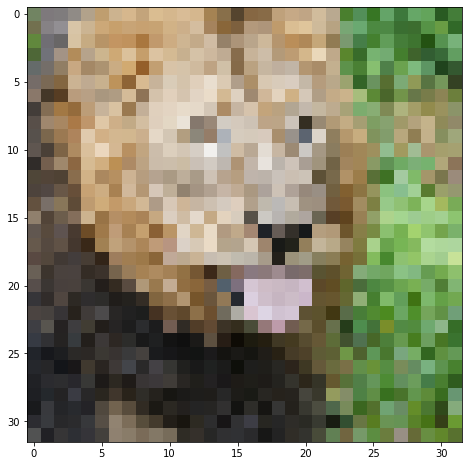

In [17]:
size = 32
train_data, test_data = get_image(size)

Some suggested hyperparameter choices to help you start
- hidden layer count: 4
- hidden layer size: 256
- number of epochs: 1000
- learning reate: 1e-4


#### Low Resolution Reconstruction - SGD - None Mapping

100%|██████████| 6000/6000 [01:53<00:00, 53.04it/s]


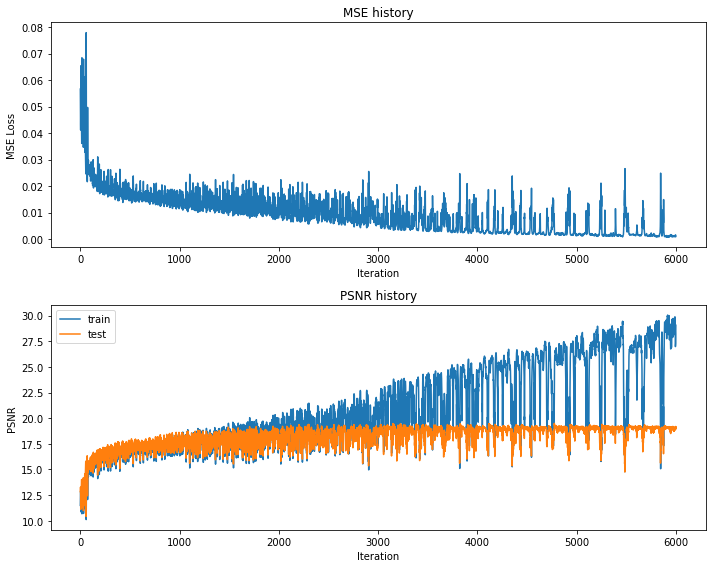

Final Test MSE 0.01090680091050647
Final Test psnr 19.132563385559877


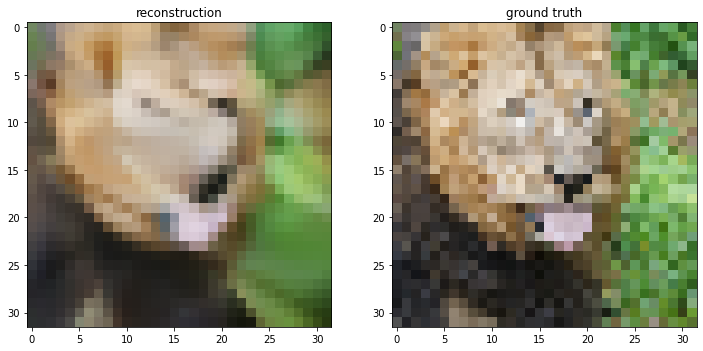

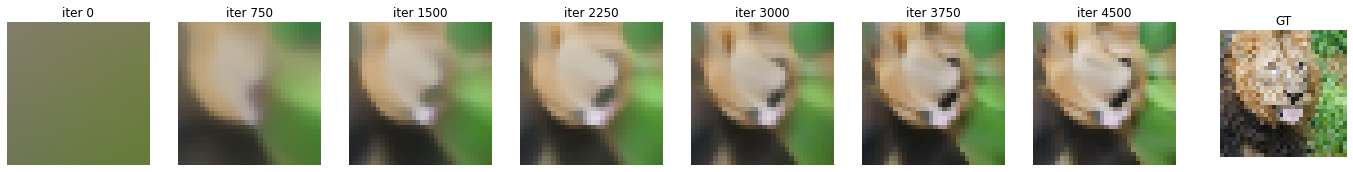

In [16]:
hidden_layer_count  = 5
num_layers          = hidden_layer_count + 1
hidden_layer_size   = 256
hidden_layer_sizes  = [64, 128, 128, 64, 64]
output_size         = 3
epochs              = 6000
learning_rate       = 10
opt                 = 'SGD'

# get input features
# TODO implement this by using the get_B_dict() and get_input_features() helper functions
B_dict                              = get_B_dict()
X_train, y_train, X_test, y_test    = get_input_features(B_dict, 'none')

# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function
input_size          = X_train.shape[1]

net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                                                            hidden_layer_size, hidden_layer_sizes, output_size, epochs, learning_rate, opt)

# plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

#### Low Resolution Reconstruction - Adam - None Mapping

100%|██████████| 3000/3000 [01:00<00:00, 49.76it/s]


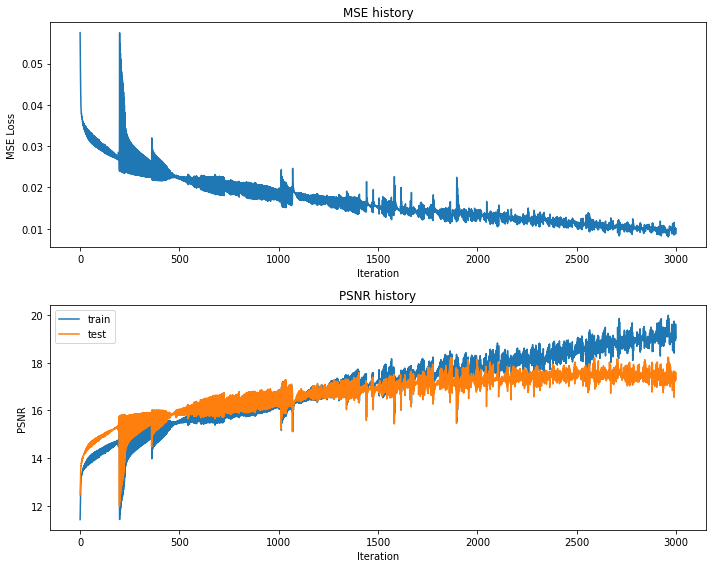

Final Test MSE 0.016611542776140895
Final Test psnr 17.30543755403566


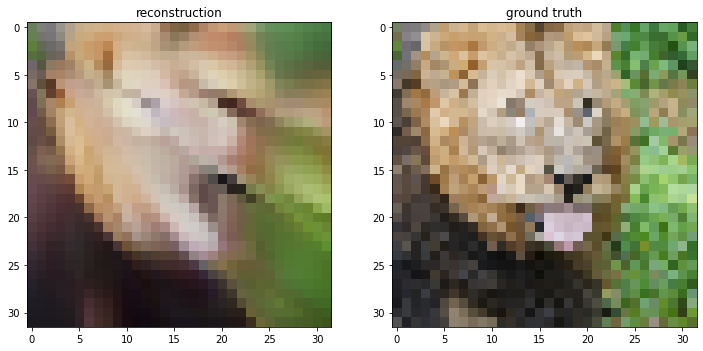

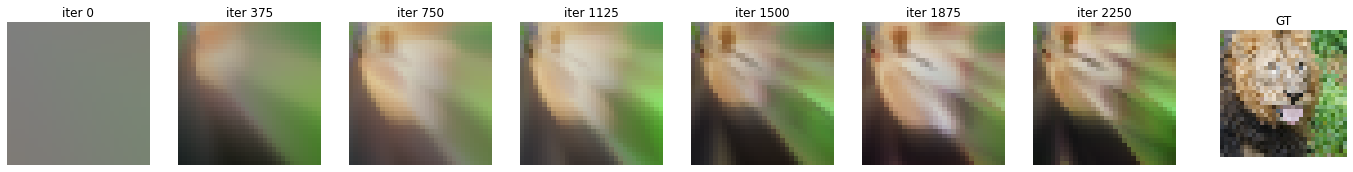

In [21]:
hidden_layer_count  = 5
num_layers          = hidden_layer_count + 1
hidden_layer_size   = 256
hidden_layer_sizes  = [64, 128, 128, 64, 64]# [512, 1024, 512, 256]
output_size         = 3
epochs              = 3000
learning_rate       = 1e-3
opt                 = 'Adam'

# get input features
# TODO implement this by using the get_B_dict() and get_input_features() helper functions
B_dict                              = get_B_dict()
X_train, y_train, X_test, y_test    = get_input_features(B_dict, 'none')

# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function
input_size          = X_train.shape[1]

net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                                                            hidden_layer_size, hidden_layer_sizes, output_size, epochs, learning_rate, opt)

# plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

#### Low Resolution Reconstruction - Optimizer of your Choice - Various Input Mapping Stategies

In [22]:
def train_wrapper(mapping, size, opt):
  # TODO implement
  # makes it easy to run all your mapping experiments in a for loop
  # this will similar to what you did previously in the last two sections

  hidden_layer_count  = 5
  num_layers          = hidden_layer_count + 1
  hidden_layer_size   = 256
  hidden_layer_sizes  = [64, 128, 128, 64, 64]
  output_size         = 3
  epochs              = 3000
  learning_rate       = 10 if opt=='SGD' else 1e-3
  
  B_dict                              = get_B_dict()
  X_train, y_train, X_test, y_test    = get_input_features(B_dict, mapping)

  input_size                                                = X_train.shape[1]
  net, train_psnr, test_psnr, train_loss, predicted_images  = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                                                                          hidden_layer_size, hidden_layer_sizes, output_size, epochs, learning_rate, opt)

  return {
      'net': net,
      'train_psnrs': train_psnr,
      'test_psnrs': test_psnr,
      'train_loss': train_loss,
      'pred_imgs': predicted_images
  }



In [19]:
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size, 'SGD')

  0%|          | 0/5 [00:00<?, ?it/s]

training none



 20%|██        | 1/5 [02:12<08:50, 132.52s/it]

training basic



 40%|████      | 2/5 [04:41<07:06, 142.02s/it]

training gauss_1.0



 60%|██████    | 3/5 [08:49<06:21, 190.52s/it]

training gauss_10.0



 80%|████████  | 4/5 [13:22<03:43, 223.29s/it]

training gauss_100.0



100%|██████████| 5/5 [18:43<00:00, 224.68s/it]


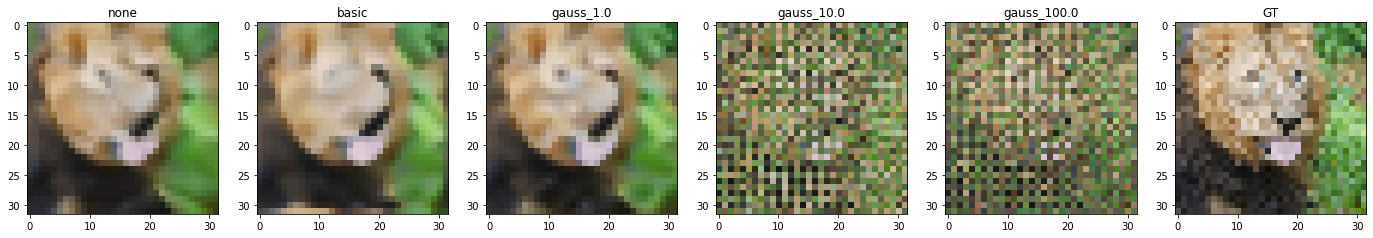

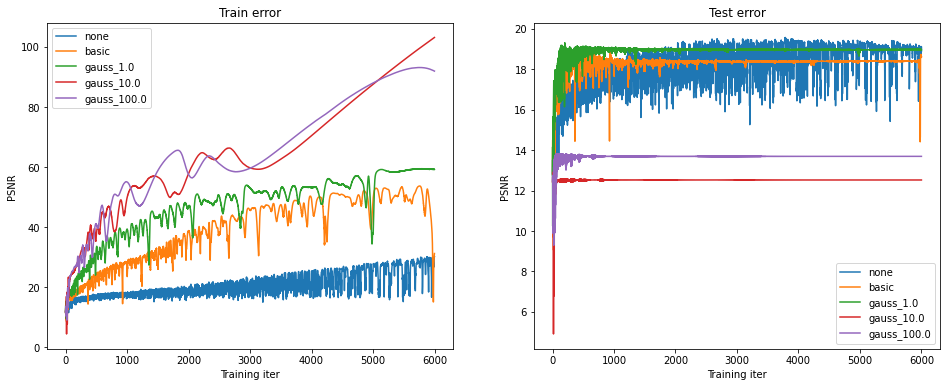

In [20]:
# if you did everything correctly so far, this should output a nice figure you can use in your report
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

In [23]:
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size, 'Adam')

  0%|          | 0/5 [00:00<?, ?it/s]

training none



 20%|██        | 1/5 [01:04<04:16, 64.16s/it]

training basic



 40%|████      | 2/5 [02:17<03:27, 69.32s/it]

training gauss_1.0



 60%|██████    | 3/5 [04:00<02:50, 85.01s/it]

training gauss_10.0



 80%|████████  | 4/5 [05:53<01:35, 95.86s/it]

training gauss_100.0



100%|██████████| 5/5 [07:47<00:00, 93.42s/it] 


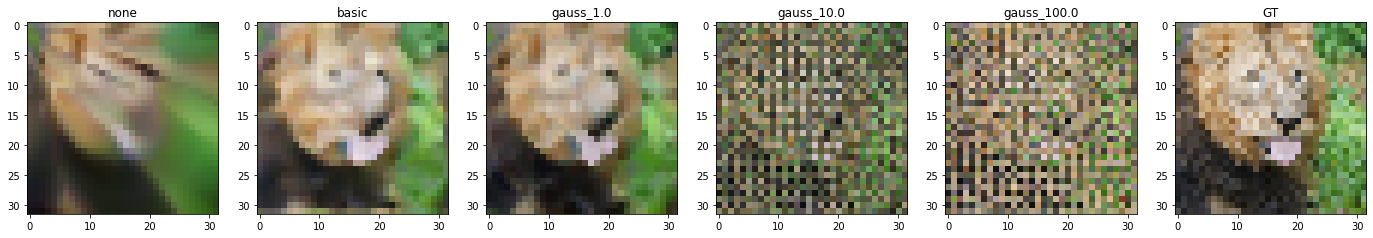

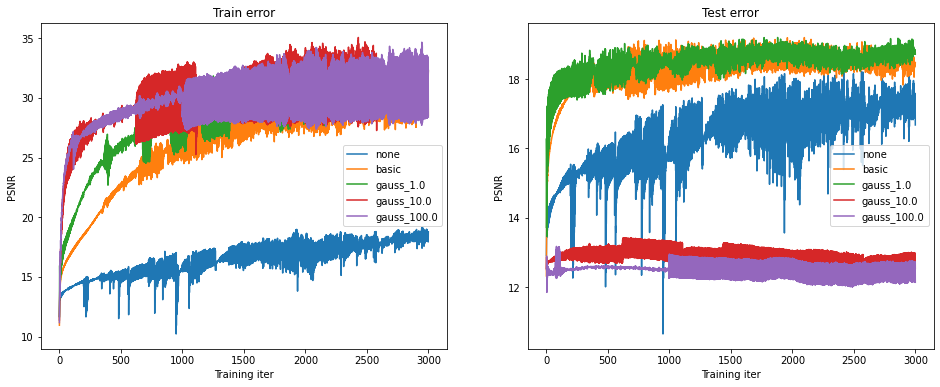

In [24]:
# if you did everything correctly so far, this should output a nice figure you can use in your report
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

# High Resolution Reconstruction

#### High Resolution Reconstruction - Optimizer of your Choice - Various Input Mapping Stategies

Repeat the previous experiment, but at the higher resolution. The reason why we have you first experiment with the lower resolution since it is faster to train and debug. Additionally, you will see how the mapping strategies perform better or worse at the two different input resolutions. 

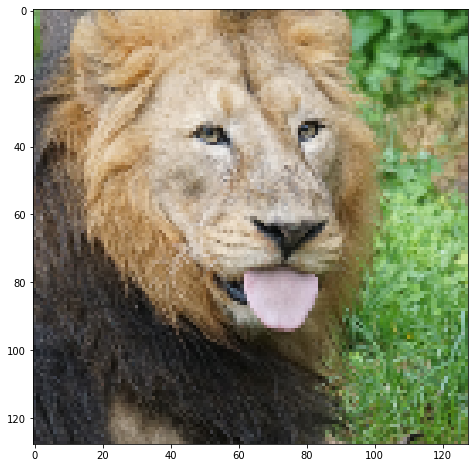

In [32]:
size = 128
train_data, test_data = get_image(size)


In [26]:
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size, 'SGD')

  0%|          | 0/5 [00:00<?, ?it/s]

training none



 20%|██        | 1/5 [13:46<55:07, 826.77s/it]

training basic



 40%|████      | 2/5 [28:33<43:05, 862.00s/it]

training gauss_1.0



 60%|██████    | 3/5 [49:54<35:06, 1053.28s/it]

training gauss_10.0



 80%|████████  | 4/5 [1:11:19<19:04, 1144.85s/it]

training gauss_100.0



100%|██████████| 5/5 [1:32:45<00:00, 1113.09s/it]


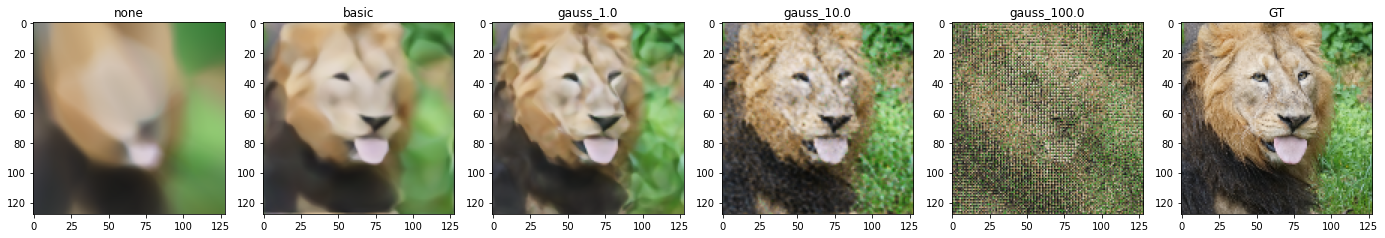

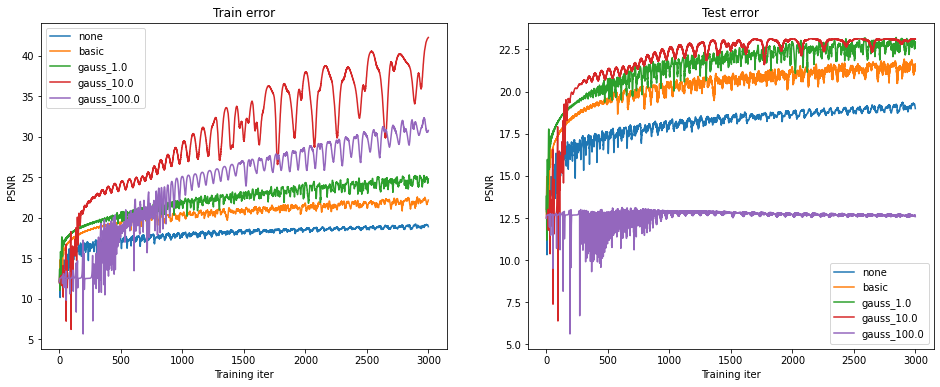

In [34]:
# if you did everything correctly so far, this should output a nice figure you can use in your report
#a , b, c, y_test    = get_input_features(B_dict, mapping)
fgh, dfg, asd, y_test    = get_input_features(B_dict, 'basic')
plot_feature_mapping_comparison(outputs, y_test.reshape(128,128,3))

#### High Resolution Reconstruction - Image of your Choice

When choosing an image select one that you think will give you interesting results or a better insight into the performance of different feature mappings and explain why in your report template. 

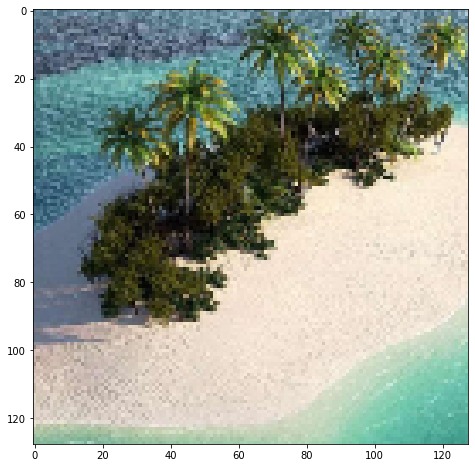

In [38]:
size = 128
# TODO pick an image and replace the url string
train_data, test_data = get_image(size, image_url="https://i.scdn.co/image/ab67616d0000b27342583462da496d39a6a6a8b9")

100%|██████████| 1000/1000 [06:06<00:00,  2.73it/s]


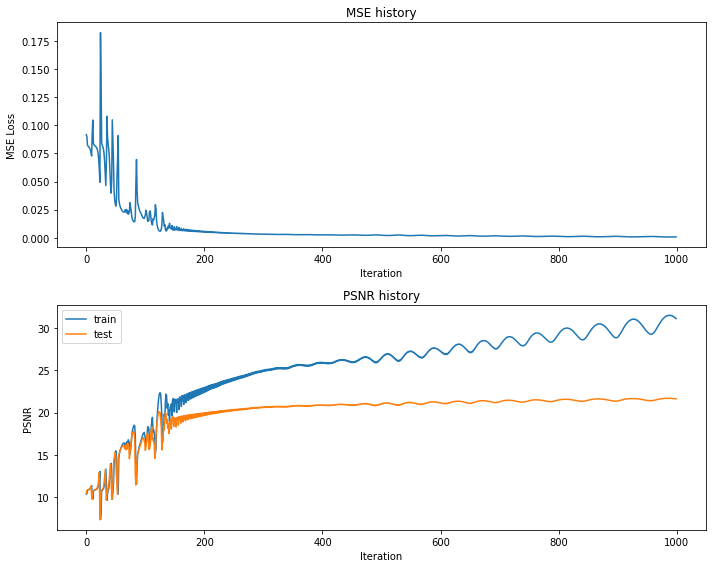

Final Test MSE 0.006859788130625321
Final Test psnr 21.636892975762294


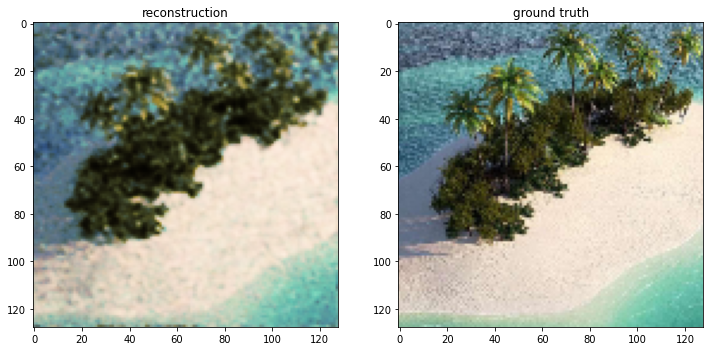

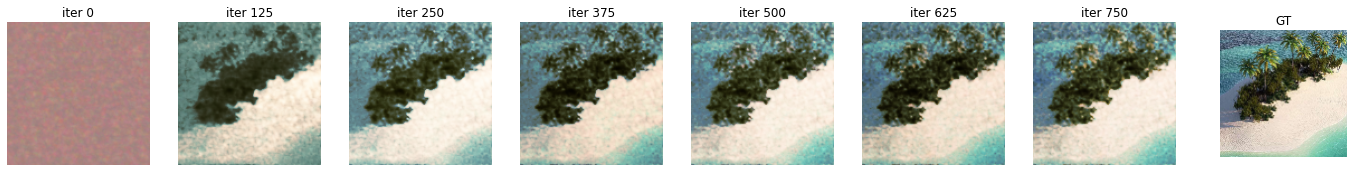

In [41]:
# get input features
# TODO implement this by using the get_B_dict() and get_input_features() helper functions

# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function

hidden_layer_count  = 5
num_layers          = hidden_layer_count + 1
hidden_layer_size   = 256
hidden_layer_sizes  = [64, 128, 128, 64, 64]# [512, 1024, 512, 256]
output_size         = 3
epochs              = 1000
learning_rate       = 10
opt                 = 'SGD'

# get input features
# TODO implement this by using the get_B_dict() and get_input_features() helper functions
B_dict                              = get_B_dict()
X_train, y_train, X_test, y_test    = get_input_features(B_dict, 'gauss_10.0')

# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function
input_size          = X_train.shape[1]

net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                                                            hidden_layer_size, hidden_layer_sizes, output_size, epochs, learning_rate, opt)

plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

# Reconstruction Process Video (Optional)
(For Fun!) Visualize the progress of training in a video 

In [42]:
# requires installing this additional dependency
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 20.0 MB/s eta 0:00:00


In [45]:
# single video example
create_and_visualize_video({"gauss": {"pred_imgs": predicted_images}}, filename="training_high_res_gauss.mp4")

In [49]:
# multi video example
create_and_visualize_video(outputs, epochs=1000, size=128)

ValueError: ignored